# GAM in EnergyML

based on statsmodels.gam.tests.test_gam.TestGAMMPG

This contains now the basic working version.


We are here working with fixed penalization weights `alpha`. Selection of penalization weights is still incomplete.

In [1]:
%matplotlib inline
import os

import numpy as np
from numpy.testing import assert_allclose
import matplotlib.pyplot as plt
import pandas as pd

import patsy
import patsy.splines as bspl
import patsy.mgcv_cubic_splines as cspl

from statsmodels.regression.linear_model import OLS
from statsmodels.discrete.discrete_model import Poisson, Logit, Probit
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod.families import family
from statsmodels.sandbox.regression.penalized import TheilGLS
from statsmodels.base._penalized import PenalizedMixin
import statsmodels.base._penalties as smpen

from statsmodels.gam.smooth_basis import (BSplines, CubicSplines,
                                          CyclicCubicSplines)
from statsmodels.gam.gam import GLMGam

In [2]:
from statsmodels.gam.tests import test_gam
from statsmodels.gam.tests.results import results_mpg_bs as res_mgcv

In [3]:
cur_dir = os.path.dirname(os.path.abspath(test_gam.__file__))

file_path = os.path.join(cur_dir, "results", "autos.csv")
df_autos_ = pd.read_csv(file_path)
df_autos = df_autos_[['city_mpg', 'fuel', 'drive', 'weight', 'hp']].dropna()

In [4]:
file_path = os.path.join(cur_dir, "results", "autos_predict.csv")
res_pred = pd.read_csv(file_path)

In [5]:
df_autos.head()

,city_mpg,fuel,drive,weight,hp
0,21,gas,rwd,2548,111.0
1,21,gas,rwd,2548,111.0
2,19,gas,rwd,2823,154.0
3,24,gas,fwd,2337,102.0
4,18,gas,4wd,2824,115.0


In [6]:
res_pred.head()

,Row.names,fit,se_fit,fit_fuel,fit_drive,fit_s_weight_,fit_s_hp.,se.fit_fuel,se.fit_drive,se.fit_s_weight_,se.fit_s_hp.
0,1,21.004549,0.649519,-5.508351,0.349134,-0.902276,-1.694105,0.869684,1.169621,0.488886,0.430747
1,2,21.004549,0.649519,-5.508351,0.349134,-0.902276,-1.694105,0.869684,1.169621,0.488886,0.430747
2,3,17.547334,0.709550,-5.508351,0.349134,-0.884486,-5.169110,0.869684,1.169621,0.607747,0.669556
3,4,23.823625,0.549217,-5.508351,2.264275,-0.282829,-1.409616,0.869684,1.132888,0.396038,0.413609
4,5,20.597137,1.201011,-5.508351,0.000000,-0.886322,-1.768336,0.869684,0.000000,0.607941,0.484633


The general model with a linear link function is

$y = X \beta + \sum_k f_k(x_k) = X \beta + \sum_k \sum_j b_{j,k} g_{j, k}(x_k)$

Each nonparametric function $f_k$ is modeled as a linear combination of basis functions $g_{j, k}$

$f_k(x_k) = \sum_j b_{j,k} g_{j, k}(x_k)$

The overall model is linear in parameters and can be estimated by a standard model like OLS or GLM. Patsy provides basis function for several types of splines that can be used with the formula interface in statsmodels. However, in this case we can use only a small number of basis functions relative to the number of observations to avoid overfitting.

As alternative we can use penalization to avoid overfitting and impose more smoothness while at the same time increasing the number of knots. The importance of the spline basis function for the fit of the data then depends on the smoothing or penalization parameters and less on the total number of basis functions.

This notebook illustrates the basic use case of a new class in statsmodels to fit generalized additive models, GAM, and penalized splines. The penalization is quadratic and similar to Ridge Regression, except that we penalize in most cases the integrated square of the second derivative of the function, and thus penalizing large fluctuations.

The implementation is based on maximum penalized loglikeliood estimation. The full GAM features are currently only implemented for GLM, but a generic penalized MLE framework can use it for any type of models that directly minimize the negative loglikelihood.

Currently two types of splines, B-splines and cyclic cubic splines, are available with similar features as and verfied against `mgcv` R package.

**Current status:**  
The core features are now verified against R mgcv, but currently only for linear Gaussian GLM.  
API is still experimental, and some parts will still change, especially also in the internal API, i.e. API for penalization and spline classes.  


The model that we are using has miles per gallon in city traffic `city_mpg` as the dependent variable.
The first two explanatory variable, 'fuel' and 'drive' are treated as linear effects, both arecategorical variables.
The effect of two continuous variables, 'weight' and horse power 'hp' are modeled by penalized B-splines.

In the following we use patsy to create a design matrix for the constant and the categorical variables.
The model will be estimated by GLMGam which takes an instance of an additive spline class as argument, so we need to create it first.

In [7]:
# penalization weights are taken from mgcv to match up its results
sp = np.array([0.830689464223685, 425.361212061649])
s_scale = np.array([2.443955e-06, 0.007945455])


x_spline = df_autos[['weight', 'hp']].values
exog = patsy.dmatrix('fuel + drive', data=df_autos)

# TODO: set `include_intercept=True` automatically if constraints='center'
bs = BSplines(x_spline, df=[12, 10], degree=[3, 3], variable_names=['weight', 'hp'], 
              constraints='center', include_intercept=True)
alpha = 1 / s_scale * sp / 2
gam_bs = GLMGam(df_autos['city_mpg'], exog=exog, smoother=bs,
                alpha=alpha)
res1a = gam_bs.fit()  # default is pirls with use_t=False

res1b = gam_bs.fit(method='newton', use_t=True)

The overall design matrix, `model.exog` has 24 columns, 4 for the linear component, 11 for the first and 9 for the second spline component.

In [8]:
gam_bs.exog.shape

(203, 24)

In [9]:
dir(exog.design_info)
exog.design_info.column_names

['Intercept', 'fuel[T.gas]', 'drive[T.fwd]', 'drive[T.rwd]']

In [10]:
k_smooth0 = res1a.model.smoother.smoothers_[0].basis_.shape[1]
k_smooth1 = res1a.model.smoother.smoothers_[1].basis_.shape[1]
k_smooth0, k_smooth1

(11, 9)

Currently the name handling is not finished. We create our own list of variable names and attach it to the model overwriting the automatically created names.

In [11]:
xnames = exog.design_info.column_names + res1a.model.smoother.col_names
xnames

['Intercept',
 'fuel[T.gas]',
 'drive[T.fwd]',
 'drive[T.rwd]',
 'weight0',
 'weight1',
 'weight2',
 'weight3',
 'weight4',
 'weight5',
 'weight6',
 'weight7',
 'weight8',
 'weight9',
 'weight10',
 'hp0',
 'hp1',
 'hp2',
 'hp3',
 'hp4',
 'hp5',
 'hp6',
 'hp7',
 'hp8']

In [12]:
xnames = exog.design_info.column_names + res1a.model.smoother.col_names
res1a.model.exog_names[:] = xnames

# Note, we could also specify the parameter names directly for summary.
# print(res1a.summary(xname=xnames))
print(res1a.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               city_mpg   No. Observations:                  203
Model:                         GLMGam   Df Residuals:                   185.10
Model Family:                Gaussian   Df Model:                        16.90
Link Function:               identity   Scale:                          4.7065
Method:                         PIRLS   Log-Likelihood:                -435.89
Date:                Tue, 13 Nov 2018   Deviance:                       871.17
Time:                        12:24:38   Pearson chi2:                     871.
No. Iterations:                     3   Covariance Type:             nonrobust
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       29.6273      1.107     26.755      0.000      27.457      31.798
fuel[T.gas]     -6.2137      0.731     -8.501 

The summary shows the usual GLM results. The parameters for the linear components can be interpreted as usually. However, the parameters for the spline basis functions do not have any clear interpretation. Specifically the original spline basis functions have been transformed to impose that the average prediction for each spline component is zero. However we can see that all except for two spline components are statistically significant and contribute to the fit.

Even though we have 24 explanatory variables or columns in the design matrix, the effective number is smaller because of the penalization. In this case we see that the effective degrees of freedom, df_model plus 1 for the constant, is 17.9.


In [13]:
res1a.df_resid, res1a.df_model + 1

(185.09998586957269, 17.900014130427309)

## Partial Prediction

A better way to see the effect of the variable that underlies the spline is to look at partial prediction. The contribution of each spline component to the linear prediction is our estimate of the nonlinear function `f` in the description of the model.

Partial prediction at the sample point can be obtained through the `partial_values` method. Instead of looking at those numbers we will provide the equivalent plots.

In [14]:
part0, part0_se = res1a.partial_values(0)
part1, part1_se = res1a.partial_values(1)

### Partial Prediction Plot with CPR
`cpr` is component plus residual. The following plots corresponds to a CCPR regression plot, available in statsmodels.graphics.

This includes also the constant, so we get the additional uncertainty. Otherwise the confidence interval of the B-splines is zero at the first point because the first basis function has been dropped to have a nonsingular design matrix.

We use resid_working for GLM. I'm not sure whether that makes sense for some link functions.

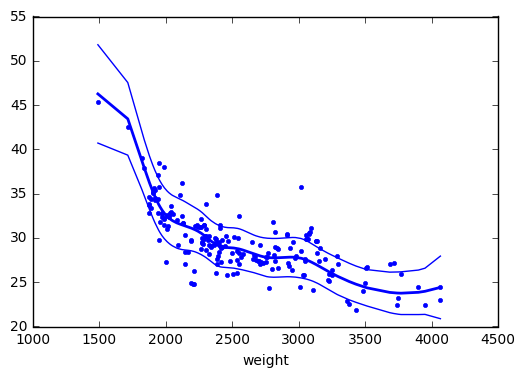

In [15]:
fig = res1a.plot_partial(0, cpr=True)

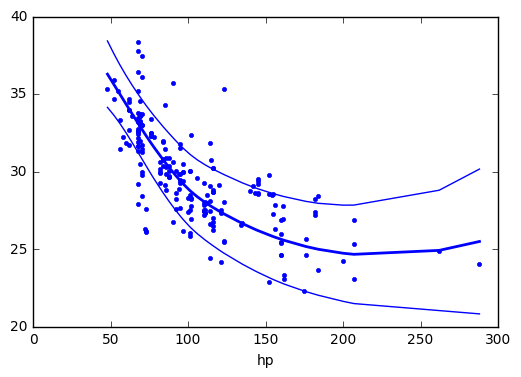

In [16]:
fig = res1a.plot_partial(1, cpr=True)

### Plot without cpr


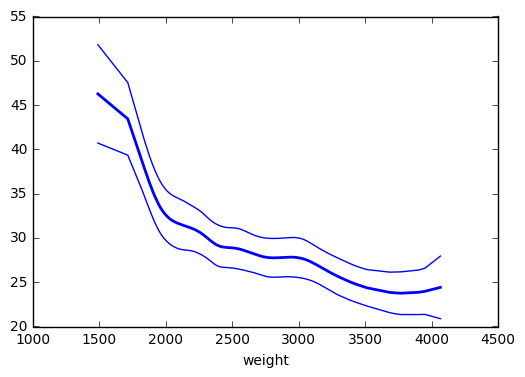

In [17]:
fig = res1a.plot_partial(0)

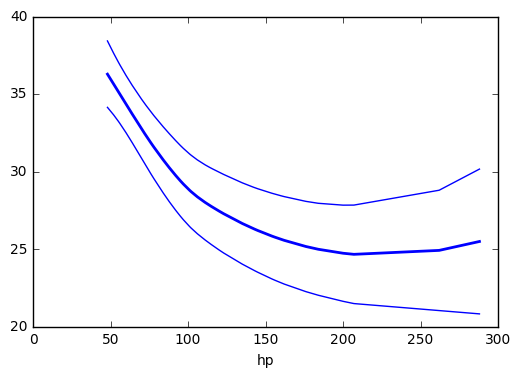

In [18]:
fig = res1a.plot_partial(1)

## Wald test

Default is using normal and chisquare distribution, i.e. `use_t=False`.  

We can use wald_test_terms for joint hypothesis when parameters that belong to the same explanatory variable can be identified by name.

**Warning:** generic wald test, i.e. those inherited from the base classes do not yet take effective degrees of freedom into account.

A model specific method, `test_significane` is available for testing whether a component modeled by the spline is zero or constant. This method takes `edf` into account. `test_significance` is a standard Wald test except that degrees of freedom have been replaced by effective degrees of freedom.

In [19]:
res1a.wald_test_terms(skip_single=True, combine_terms=['fuel', 'drive', 'weight', 'hp'])

<class 'statsmodels.stats.contrast.WaldTestResults'>
              chi2                  P>chi2  df constraint
fuel     72.260652  1.8857012798855524e-17              1
drive     3.509491     0.17295123773359317              2
weight  131.205902   9.923257765194286e-23             11
hp       70.116213  1.4448532927533344e-11              9

results when use_t is True

In [20]:
res1b.wald_test_terms(skip_single=True, combine_terms=['fuel', 'drive', 'weight', 'hp'])

<class 'statsmodels.stats.contrast.WaldTestResults'>
                F                     P>F  df constraint    df denom
fuel    72.260652    6.17307890496181e-15              1  185.099986
drive    1.754746     0.17581588475526833              2  185.099986
weight  11.927809   9.135620948653085e-17             11  185.099986
hp       7.790690  1.0522812964137523e-09              9  185.099986

In [21]:
res1b.test_significance(0)

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[ 12.79612043]]), p=4.10817312103462e-17, df_denom=185, df_num=10.3>

In [22]:
res1b.test_significance(1)

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[ 19.22864809]]), p=1.9378091125595854e-12, df_denom=185, df_num=3.65>

We can compare results with mgcv. 

Our values are close to those of mgcv but there is a difference where it is not clear where it comes from. statsmodels and mgcv have the same edf, but mgcv might be using `Ref.df`. H the p-values are very small in this example and there might be only minor differences for larger p-values resulting from small differences in the df or edf used in the hypothesis test.



```
> summary(gam_a)

Family: gaussian 
Link function: identity 

Formula:
city.mpg ~ fuel + drive + s(weight, bs = "bs", k = 12) + s(hp, 
    bs = "bs", k = 10)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  29.6273     1.1074  26.755  < 2e-16 ***
fuelgas      -6.2137     0.7310  -8.501 6.17e-15 ***
drivefwd      1.4399     0.8027   1.794   0.0745 .  
driverwd      1.0113     0.8272   1.223   0.2230    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
             edf Ref.df     F  p-value    
s(weight) 10.254 10.806 12.22  < 2e-16 ***
s(hp)      3.646  4.395 15.78 6.22e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.891   Deviance explained =   90%
GCV = 5.1616  Scale est. = 4.7065    n = 203
```

In [23]:
res1a.model.data.const_idx

array(0, dtype=int64)

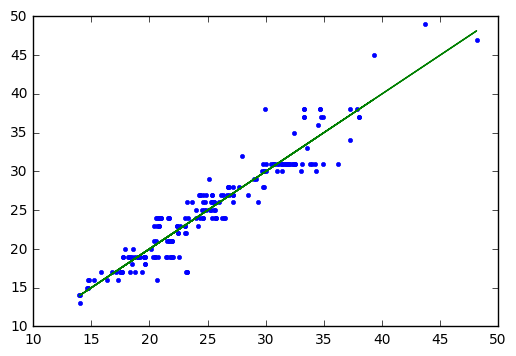

In [24]:
plt.plot(res1a.fittedvalues, res1a.model.endog, '.')
plt.plot(res1a.fittedvalues, res1a.fittedvalues, '-')

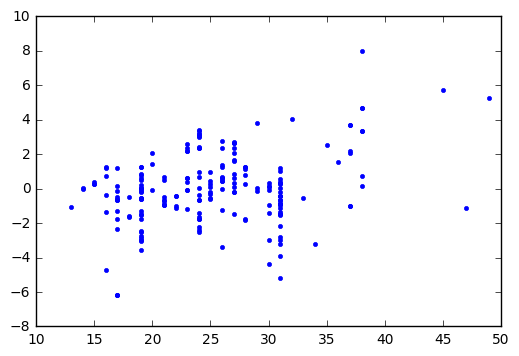

In [25]:
plt.plot(res1a.model.endog, res1a.resid_response, '.')

## Variable addition score test

We can use the score test to test whether the restricted model with only linear terms is appropriate or whether that model is rejected in favor of adding splines.

The problem here is that the spline basis also includes an implicit linear term. The score_test does not take this into account and reports the number of constraints equal to the number of columns instead of the dimension of the subspace that is in addition to the already included exog.

**Warning:** GLM.score_test is currently a "hidden", not-advertised method, which means it is a prototype for experimental use but will be replaced by an official GLMResults method, which is currently waiting in a pull request.

In the following we estimate a GLM with linear components, and then test whether adding spline components is statistically significant.  
However the current score test does not take the linear dependence of the spline component with already included variables into account when computing the degrees of freedom for the constraint. As workaround we use two helper functions, `partial_project` and `pca`, to compute the contribution of the spline component that is orthogonal to the already included linear term. This does not change the test chi-square statistic but reduces the degrees of freedom for the constraint to 18.

As we can see from the results, the score_test for variable addition and therefore the linear specification is rejected, and we should add the spline component.

**Note** This is a test with the alternative of adding all spline basis functions to the model and not a hypothesis test of adding a penalized version of it. Effective degrees of freedom are not used.

As in the Wald test, the hypothesis that the linear specification is correct is strongly rejected.


In [26]:
mod_glm = GLM.from_formula('city_mpg ~ fuel + drive + weight + hp', df_autos)
res_glm = mod_glm.fit()

In [27]:
res_glm.model.score_test(res_glm.params, exog_extra=bs.basis_)

(array([ 108.91677455]), array([  3.09383926e-14]), 20)

In [28]:
bs.basis_.shape

(203, 20)

In [29]:
from statsmodels.stats.multivariate_tools import partial_project
projection_resid = partial_project(bs.basis_, res_glm.model.exog)

In [30]:
np.linalg.matrix_rank(projection_resid.resid), projection_resid.resid.shape[1]

(18, 20)

In [31]:
res_glm.model.score_test(res_glm.params, exog_extra=bs.basis_)


(array([ 108.91677455]), array([  3.09383926e-14]), 20)

In [32]:
from statsmodels.sandbox.tools.tools_pca import pca

In [33]:
red = pca(projection_resid.resid, keepdim=18, demean=False)[1]
res_glm.model.score_test(res_glm.params, exog_extra=red)

(array([ 108.91677455]), array([  5.00598345e-15]), 18)

## Prediction for new observations

Prediction currently requires the design matrix for the linear part and the variables that are used for the spline parts.
Full formula support with automatic design matrix creation is still missing.

First we construct a new dataframe for the observations for which we compute the prediction, i.e. conditional expectation. In this example we consider a car that uses gasoline as fuel and has a front wheel drive. We use five percentiles for each of the smooth terms, weight and horse power.

Next we use patsy.dmatrix to create our new design matrix for the linear part. Note that this is a stateful transform and we need to provide the original design matrix, so patsy can correctly convert the categorical variables to dummy variables.

In [34]:
df_new = df_autos[['weight', 'hp']].quantile([0.1, 0.25, 0.5, 0.75, 0.9])
df_new['fuel'] = 'gas'
df_new['drive'] = 'fwd'
df_new

,weight,hp,fuel,drive
0.10,1946.0,68.0,gas,fwd
0.25,2145.0,70.0,gas,fwd
0.50,2414.0,95.0,gas,fwd
0.75,2943.5,116.0,gas,fwd
0.90,3230.0,160.0,gas,fwd


In [35]:
# note stateful transform
exog_linear_new = patsy.dmatrix(exog.design_info, df_new, return_type="dataframe")

In [36]:
# TODO: smooth x cannot be a dataframe
res1b.predict(exog_linear_new, df_new[['weight', 'hp']].values)

array([ 32.4405619 ,  29.71396177,  24.02805174,  21.11556954,  17.37701468])

We varied both smooth terms at the same time. Instead we can vary only one smooth term and keep the other term at its mean.

In [37]:
df_new2 = df_new.copy()
df_new2['weight'] = df_new['weight'].mean()
res1b.predict(exog_linear_new, df_new2[['weight', 'hp']].values)

array([ 27.47259444,  27.15972987,  23.80511056,  22.08912555,  20.02775013])

In [38]:
df_new3 = df_new.copy()
df_new3['hp'] = df_new['hp'].mean()
res1b.predict(exog_linear_new, df_new3[['weight', 'hp']].values)

array([ 28.08722431,  25.67348875,  23.34219804,  22.14570084,  20.4685214 ])

`predict` only computes the expected value for a new observations. Instead, we can use the `get_prediction` method which returns a prediction results instance with additional attributes and methods such as standard errors and confidence intervals for the predicted mean.

In [39]:
pred = res1b.get_prediction(exog_linear_new, df_new3[['weight', 'hp']].values)
pred.predicted_mean

array([ 28.08722431,  25.67348875,  23.34219804,  22.14570084,  20.4685214 ])

In [40]:
pred.se_mean

array([ 0.71039517,  0.63746064,  0.4644517 ,  0.63797194,  0.79398475])

In [41]:
pred.conf_int()

array([[ 26.68571202,  29.4887366 ],
       [ 24.41586629,  26.93111121],
       [ 22.42589849,  24.25849758],
       [ 20.88706965,  23.40433203],
       [ 18.90209832,  22.03494447]])

## Choosing the smoothing or penalty parameter

At the moment there is no built-in method to choose the penalty parameters `alpha`.

In the following we use scipy optimizers to minimize several selection criteria, gcv, aic and bic which are available as attributes of the results instance.  
The code below investigates the possibility of multiple local minima or near minima at which optimizers end up and differences across selection criteria.


see https://github.com/statsmodels/statsmodels/issues/5381 which includes the following

It can be difficult to minimize aic, bic or gcv to find the optimial smoothing or penalty parameter in GAM.

I looked at the behavior of scipy optimizers when only the objective function is provided. (mgcv also has approximate derivative but I have not included any.)
The example is miles per gallon in city traffic depending on 2 categorical variable and 2 smooth, B-spline terms, weight and horse power. The correlation between weight and horse power is 0.75 and both variables have a similar downward sloping effect on mpg.

- Penalization parameters have to be positive or non-negative, so it is best to use a log-link, i.e. use exp(alpha) for the  optimization
- The penalty parameter estimates depends on starting values and optimization method, nelder-mead, bfgs or basinhopping.
using basinhopping with nelder-mead seems to converge resonably well to the same values from different start_params. Using default lbfgsb with basinhopping did not look good.
- none of the estimated penalty parameters are close to those of mgcv. But mgcv values are large and there does not seem to be much effect of varying the penalty parameter in that range.
- aic undersmooths for some penalty parameter estimates, often undersmooths only one component
- gcv has very smooth estimate, and likely oversmooths
- using the average between aic and gcv estimate looks good in graph.

This means we/users need to check the results in case the optimizer gets ends in local optima or near-optima.
One possibility is to start gcv minimization at the aic estimate and vice-versa to avoid that those are in different local optima.
Another possibility in case of high correlation would be to change the penalty parameters in opposite direction for new starting values, eg. double one and half the other. This would help in case when a local minimum has one spline function oversmoothed and the other undersmoothed.

**visual inspection**  
using the plot_partial method can be used to quickly see the smoothness of the estimated partial prediction
fig = res_aic.plot_partial(0, cpr=True)

**current computational structure:**

we can use the internal fit_pirls to change the penalization parameter alpha during the optimization.
The fit method currently does not have an alpha argument and we need to create a new model with the chosen alpha. The smoother or spline instance can be reused when creating a new model.  
Currently we cannot have several results instances that are based on different alpha and hold the same model instance because the alpha is a model attribute and not a results parameter.  
This structure will likely change in future versions.


In [42]:
from scipy.optimize import fmin, fmin_bfgs, minimize, basinhopping
x = np.array([0, 0])

In [43]:
alpha  # mgcv equivalent

array([ 169947.7822267,   26767.5804634])

In [44]:
fun = lambda p: gam_bs._fit_pirls(alpha=[np.exp(p[0]), np.exp(p[1])]).aic
x = x_aic = fmin(fun, np.log(alpha).tolist())
x, np.exp(x)

Optimization terminated successfully.
         Current function value: 907.347699
         Iterations: 36
         Function evaluations: 67


(array([ 11.22682894,   9.86966346]),
 array([ 75119.01041465,  19334.83085966]))

In [45]:
fun = lambda p: gam_bs._fit_pirls(alpha=[np.exp(p[0]), np.exp(p[1])]).gcv
x = x_gcv = fmin(fun, x_aic)
x, np.exp(x)

Optimization terminated successfully.
         Current function value: 5.653825
         Iterations: 34
         Function evaluations: 65


(array([ 12.39068244,  10.79505194]),
 array([ 240549.80518384,   48778.84240277]))

In [46]:
#x = np.array([1, 1])
history = []
history_params = []

In [47]:
def fun(p, objective='aic'): 
    res = gam_bs._fit_pirls(alpha=[np.exp(p[0]), np.exp(p[1])])
    history_params.append(p)
    history.append([res.aic, res.gcv, res.bic, res.cv])
    
    return getattr(res, objective)

x_aic = x = fmin(fun, x)
x, np.exp(x)

Optimization terminated successfully.
         Current function value: 907.347699
         Iterations: 35
         Function evaluations: 68


(array([ 11.2268819 ,   9.86965926]), array([ 75122.9888025,  19334.7496646]))

In [48]:
hist_p = np.asarray(history_params)

In [49]:
hist = np.asarray(history)
hist_res = np.column_stack((hist_p, hist))

In [50]:
sort_idx = hist_p[:,0].argsort(0)
#hist_res[sort_idx]
col_names = 'p0 p1 aic gcv bic cv'.split()
df_hist = pd.DataFrame(hist_res, columns=col_names)
df_hist

,p0,p1,aic,gcv,bic,cv
0,12.390682,10.795052,908.158316,5.653825,-107.714598,7.082931
1,13.010217,10.795052,908.832263,5.656113,-103.213774,6.639704
2,12.390682,11.334805,908.847521,5.660265,-103.506104,7.103010
3,13.010217,10.255299,908.547175,5.661834,-105.761468,6.636342
4,12.390682,10.255299,907.849184,5.658978,-110.331291,7.072854
5,12.080915,9.985423,907.572446,5.665391,-112.809554,7.328070
6,11.461381,10.525176,907.546826,5.660812,-112.569566,8.050819
7,10.686964,10.660114,907.673366,5.669177,-112.464454,9.643831
8,11.151614,9.715547,907.357574,5.681645,-115.707177,8.488434
9,10.532080,9.175794,907.563087,5.709325,-116.730225,9.852919


In [51]:
min_idx = np.argmin(hist, 0)
min_idx

array([65,  0,  9,  3], dtype=int64)

In [52]:
hist_p[min_idx], np.exp(hist_p[min_idx])

(array([[ 11.2268819 ,   9.86965926],
        [ 12.39068244,  10.79505194],
        [ 10.53208007,   9.17579415],
        [ 13.01021656,  10.25529934]]),
 array([[  75122.9888025 ,   19334.7496646 ],
        [ 240549.80518384,   48778.84240277],
        [  37499.39474376,    9660.43685657],
        [ 446956.50254215,   28432.81865686]]))

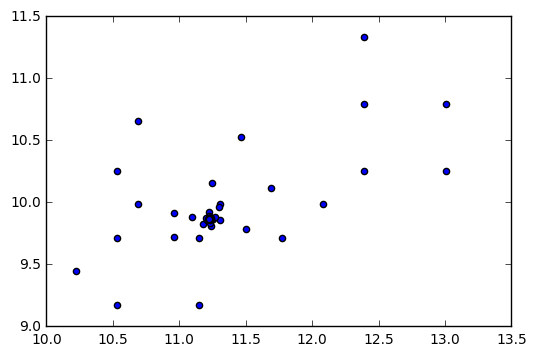

In [53]:
plt.scatter(hist_p[:,0], hist_p[:, 1])

In [54]:
df_hist.iloc[min_idx]

,p0,p1,aic,gcv,bic,cv
65,11.226882,9.869659,907.347699,5.676051,-115.281676,8.369268
0,12.390682,10.795052,908.158316,5.653825,-107.714598,7.082931
9,10.532080,9.175794,907.563087,5.709325,-116.730225,9.852919
3,13.010217,10.255299,908.547175,5.661834,-105.761468,6.636342


In [55]:
# some previous results with different starting values and optimizers
a_minaic = [ 112487.6132559 ,     129.89530824]
a_minaic = [  75122.9888025 ,   19334.7496646 ]
a_minaic = [  1.84554244e+00,   1.95130433e+04] # basinhopping default
a_minaic = [112486.36013144413, 129.8919251893982] # basinhopping nm
a_mingcv = [19643062.097191658, 49251.418095354195] # basinhopping nm
a_minbic = [73696.07497684428, 62.55870150328582]  # basinhopping nm

a_mingcv = np.exp(x_gcv)
a_minaic = np.exp(x_aic)
a = a_minaic
a = a_mingcv
a = a_minbic

# use average of aic and gcv estimate
a = (a_minaic + a_mingcv) / 2
gam_bs_aic = GLMGam(df_autos['city_mpg'], exog=exog, smoother=bs,
                alpha=a)
res1_aic = gam_bs_aic.fit()

In [56]:
a, a_minaic, a_mingcv

(array([ 157836.39699317,   34056.79603368]),
 array([ 75122.9888025,  19334.7496646]),
 array([ 240549.80518384,   48778.84240277]))

In [57]:
res1_aic.edf.sum()

17.762842296343244

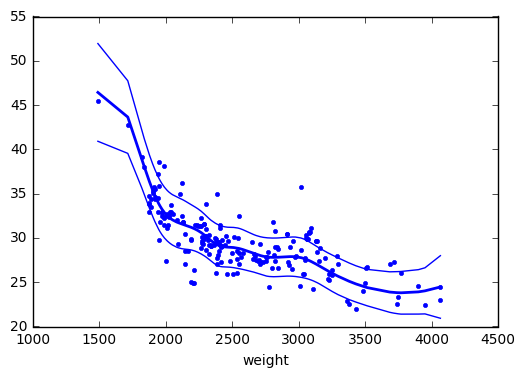

In [58]:
fig = res1_aic.plot_partial(0, cpr=True)

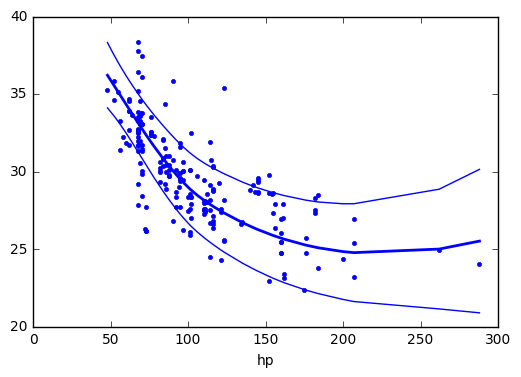

In [59]:
fig = res1_aic.plot_partial(1, cpr=True)

In [60]:
basinhopping(fun, x, minimizer_kwargs={'method': 'Nelder-Mead'}, niter=10)

                        fun: 907.34769921075156
 lowest_optimization_result:  final_simplex: (array([[ 11.22684271,   9.8696653 ],
       [ 11.22684067,   9.8696088 ],
       [ 11.22691188,   9.86962771]]), array([ 907.34769921,  907.34769921,  907.34769921]))
           fun: 907.34769921075156
       message: 'Optimization terminated successfully.'
          nfev: 58
           nit: 29
        status: 0
       success: True
             x: array([ 11.22684271,   9.8696653 ])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 0
                       nfev: 654
                        nit: 10
                          x: array([ 11.22684271,   9.8696653 ])

In [61]:
np.exp(np.array([ 0.61277324,  9.87883841])).tolist()

[1.845542440551041, 19513.043336567418]

In [62]:
np.exp(np.array([11.63058725,   4.86670276])).tolist()

[112486.36013144413, 129.8919251893982]

In [63]:
basinhopping(lambda p: fun(p, objective='gcv'), x, minimizer_kwargs={'method': 'Nelder-Mead'}, niter=10)

                        fun: 5.6538245393041597
 lowest_optimization_result:  final_simplex: (array([[ 12.39062742,  10.79502202],
       [ 12.39058025,  10.7950683 ],
       [ 12.39066756,  10.79508847]]), array([ 5.65382454,  5.65382454,  5.65382454]))
           fun: 5.6538245393041597
       message: 'Optimization terminated successfully.'
          nfev: 62
           nit: 31
        status: 0
       success: True
             x: array([ 12.39062742,  10.79502202])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 0
                       nfev: 681
                        nit: 10
                          x: array([ 12.39062742,  10.79502202])

In [64]:
# min gcv
np.exp(np.array([16.79323476,  10.80469344])).tolist()  

[19643062.097191658, 49251.418095354195]

In [65]:
basinhopping(lambda p: fun(p, objective='bic'), x, minimizer_kwargs={'method': 'Nelder-Mead'}, niter=10)

                        fun: -127.34066179693878
 lowest_optimization_result:  final_simplex: (array([[ 11.20770641,   4.13606207],
       [ 11.20773554,   4.13609134],
       [ 11.20767237,   4.13615912]]), array([-127.3406618 , -127.3406618 , -127.34066179]))
           fun: -127.34066179693878
       message: 'Optimization terminated successfully.'
          nfev: 64
           nit: 33
        status: 0
       success: True
             x: array([ 11.20770641,   4.13606207])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 0
                       nfev: 703
                        nit: 10
                          x: array([ 11.20770641,   4.13606207])

In [66]:
# min bic
np.exp(np.array([11.20770482,   4.13610534])).tolist()  

[73696.07497684428, 62.55870150328582]

In [67]:
df_autos.corr()

,city_mpg,weight,hp
city_mpg,1.000000,-0.758145,-0.803620
weight,-0.758145,1.000000,0.751034
hp,-0.803620,0.751034,1.000000


### basic recipe for penality parameter optimization

The following code summarizes the basic current pattern for choosing the penalization parameter and visualizing the estimated smooth function.

This just uses Nelder-Mead as optimizer which could be replaced by other optimizers like basinhopping.

Optimization terminated successfully.
         Current function value: 907.222821
         Iterations: 116
         Function evaluations: 216
[ 11.63059839   4.8667288 ] [ 112487.6132559      129.89530824]


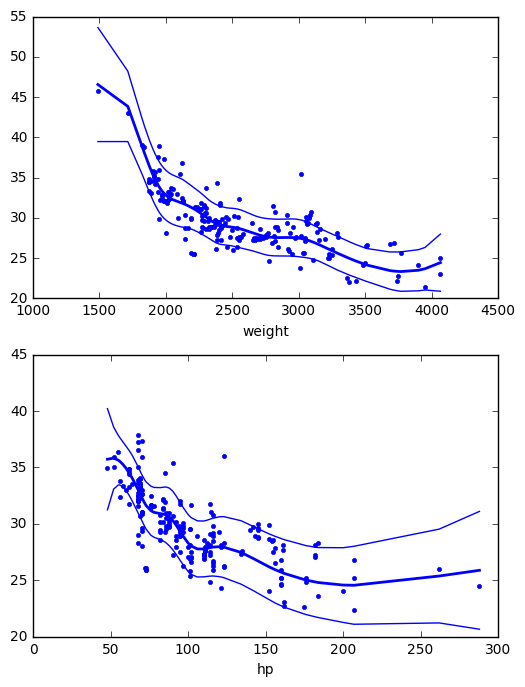

In [68]:
x0 = [0, 0]
fun = lambda p: gam_bs._fit_pirls(alpha=[np.exp(p[0]), np.exp(p[1])]).aic
a = fmin(fun, x0)
print(a, np.exp(a))
gam_bs_aic = GLMGam(df_autos['city_mpg'], exog=exog, smoother=bs,
                alpha=np.exp(a))
res_aic = gam_bs_aic.fit()

fig = plt.figure(figsize=(6, 8))
ax0 = fig.add_subplot(211)
fig = res_aic.plot_partial(0, cpr=True, ax=ax0)
ax1 = fig.add_subplot(212)
fig = res_aic.plot_partial(1, cpr=True, ax=ax1)

In [69]:
x0 = [1, 1]
basinhopping(fun, x0, minimizer_kwargs={'method': 'Nelder-Mead'}, niter=10)

                        fun: 907.22282095619732
 lowest_optimization_result:  final_simplex: (array([[ 11.63059094,   4.8667184 ],
       [ 11.63058094,   4.86666148],
       [ 11.63050623,   4.86670023]]), array([ 907.22282096,  907.22282096,  907.22282096]))
           fun: 907.22282095619732
       message: 'Optimization terminated successfully.'
          nfev: 66
           nit: 34
        status: 0
       success: True
             x: array([ 11.63059094,   4.8667184 ])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 0
                       nfev: 759
                        nit: 10
                          x: array([ 11.63059094,   4.8667184 ])